In [1]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline


Gaussian boson sampling and the Hafnian
=======================================

> "The extended Church-Turing thesis states that *'Any algorithmic process can be simulated efficiently using a probabilistic Turing machine'.* This ad-hoc modification of the Church-Turing thesis should leave you feeling rather queasy." --- Nielsen and Chuang [1].

In this tutorial, we will walk through the application of Gaussian boson sampling.$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$

Background theory
-----------------

Introduced by Hamilton et al. [2], and inspired by an earlier approach of Aaronson and Arkhipov [3], Gaussian boson sampling (GBS) presented a slight deviation from the general approach in quantum computation. Rather than presenting a theoretical model of universal quantum computation (i.e., a framework that enables quantum simulation of any arbitrary Hamiltonian [1]), Gaussian boson sampling-based devices are instead an example of an **intermediate quantum computer**, designed to experimentally implement a computation that is thought to be intractable classically.

Gaussian boson sampling proposes the following [quantum linear optics](https://en.wikipedia.org/wiki/Linear_optical_quantum_computing) scheme:

* $N$ single mode squeezed states $\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$\ket{z}$, with squeezing parameter
  $z=re^{i\phi}$, enter an $N$ mode linear interferometer described by unitary $U$
  simultaneously.

* Each output mode of the [interferometer](https://en.wikipedia.org/wiki/Interferometry) (denoted by state $\ket{\psi'}$) is then measured in the Fock basis, $\bigotimes_i n_i\ket{n_i}\bra{n_i}$.

Without loss of generality, we can absorb the squeezing phase parameter $\phi$ into the
interferometer, and set $\phi=0$ for convenience.

Using phase space methods, Hamilton et al. [2] showed that the probability of
measuring a Fock state containing only 0 or 1 photons per mode is given by

$$
\left|\left\langle{n_1,n_2,\dots,n_N}\middle|{\psi'}\right\rangle\right|^2 =
    \frac{\left|\text{Haf}[(U(\bigoplus_i\tanh(r_i))U^T)]_{st}\right|^2}{\prod_{i=1}^N \cosh(r_i)}
$$

i.e., the sampled single photon probability distribution is proportional to the **hafnian** of a
submatrix of $U(\bigoplus_i\tanh(r_i))U^T$, dependent upon the output covariance matrix.

### **Note:** 

The hafnian of a matrix is defined by

$$
\text{Haf}(A) = \frac{1}{n!2^n}\sum_{\sigma \in S_{2N}}\prod_{i=1}^N A_{\sigma(2i-1)\sigma(2i)}
$$

where $S_{2N}$ is the set of all permutations of $2N$ elements. In graph theory, the
hafnian calculates the number of perfect [matchings](https://en.wikipedia.org/wiki/Matching_(graph_theory)) in an **arbitrary graph** with adjacency matrix $A$.

Computing the hafnian, even approximately, belongs to the computational complexity class of #P-Hard problems [4], which are strongly believed to be classically hard to calculate. [2] gives strong theoretical arguments that the hafnians arising from the GBS probability distributions are also #P-hard to approximate. This implies that simulating Gaussian boson sampling cannot be done efficiently on a classical computer, providing a potential challenge to the extended Church-Turing thesis, and demonstrating the power of (non-universal) quantum computation.

Circuit construction and simulation
-----------------------------------

In quantum linear optics, the multimode linear interferometer is commonly decomposed into two-mode
beamsplitters ([``BSgate``](https://strawberryfields.readthedocs.io/en/stable/code/api/strawberryfields.ops.BSgate.html)) and single-mode phase shifters ([``Rgate``](https://strawberryfields.readthedocs.io/en/stable/code/api/strawberryfields.ops.Rgate.html))
[5], allowing for a straightforward translation into a CV quantum circuit.

For example, in the case of a 4 mode interferometer, with arbitrary $4\times 4$ unitary
$U$, the CV quantum circuit for Gaussian boson sampling is given by

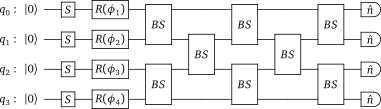

In the above, the single mode squeeze states all apply identical squeezing $z=r$, the
parameters of the beamsplitters and the rotation gates determine the unitary $U$, and finally
the detectors perform Fock state measurements on the output modes. Note that, in order to allow for arbitrary
linear unitaries for $m$ imput modes, we must have a minimum of $m+1$ columns in the
beamsplitter array [6].

Simulating this circuit using Strawberry Fields is easy; we can simply read off the gates from left
to right, and convert it into the Blackbird circuit language.

To begin, we create the Gaussian boson sampling quantum program using Strawberry Fields:

In [2]:
import numpy as np

# set the random seed
np.random.seed(42)

# import Strawberry Fields
import strawberryfields as sf
from strawberryfields.ops import *

# initialize a 4 mode program
gbs = sf.Program(4)

with gbs.context as q:
    # prepare the input squeezed states
    S = Sgate(1)
    S | q[0]
    S | q[1]
    S | q[2]
    S | q[3]

    # rotation gates
    Rgate(0.5719)  | q[0]
    Rgate(-1.9782) | q[1]
    Rgate(2.0603)  | q[2]
    Rgate(0.0644)  | q[3]

    # beamsplitter array
    BSgate(0.7804, 0.8578)  | (q[0], q[1])
    BSgate(0.06406, 0.5165) | (q[2], q[3])
    BSgate(0.473, 0.1176)   | (q[1], q[2])
    BSgate(0.563, 0.1517)   | (q[0], q[1])
    BSgate(0.1323, 0.9946)  | (q[2], q[3])
    BSgate(0.311, 0.3231)   | (q[1], q[2])
    BSgate(0.4348, 0.0798)  | (q[0], q[1])
    BSgate(0.4368, 0.6157)  | (q[2], q[3])

A couple of things to note in this particular example:

1. To prepare the input single mode squeezed vacuum state $\ket{z}$ where $z = 1$, we
   apply a squeezing gate [``Sgate``](https://strawberryfields.readthedocs.io/en/stable/code/api/strawberryfields.ops.Sgate.html) to each of the modes (initially in the vacuum state).

2. Next we apply the rotation gates, [``Rgate``](https://strawberryfields.readthedocs.io/en/stable/code/api/strawberryfields.ops.Rgate.html), to each mode. The resulting rotation in the phase space occurs in the anticlockwise direction, with angle $\phi$.

3. Finally, we apply the array of beamsplitters, using the [``BSgate``](https://strawberryfields.readthedocs.io/en/stable/code/api/strawberryfields.ops.BSgate.html) operator, with arguments ``(theta,phi)``.

   * The transmission amplitude is then given by $t=\cos\theta$
   * The reflection amplitude is given by $r=e^{i\phi}\sin{\theta}$


4. The rotation gate and beamsplitter parameters have been chosen at random, leading to an
   arbitrary unitary $U$ acting on the input modes annihilation and creation operators.
   After leaving the beamsplitter array, we will denote the output state by $\ket{\psi'}$.

5. We are **not** performing Fock measurements at the output; this is to ensure the state is
   preserved, so we can extract the joint Fock state probabilities after the beamsplitter array.

   If we wish to simulate Fock measurements, we can additionally include

   ```
       MeasureFock() | q
   ```

   after the beamsplitter array. After constructing the circuit and running the engine, the values of
   the Fock state measurements will be available within the ``samples`` attribute of the
   [``Result``](https://strawberryfields.readthedocs.io/en/stable/code/api/strawberryfields.Result.html) object returned by the engine.

Now that the program is created, we can initialize an engine, and execute the program
on one of the built-in Strawberry Fields state simulators.  We will use the Numpy-based ``'gaussian'`` backend, along with a 4-mode register. The Gaussian backend is perfectly suited for simulation of Gaussian boson sampling, as all initial states are Gaussian, and all the required operators transform Gaussian states to other Gaussian states.

In [3]:
eng = sf.Engine(backend="gaussian")
results = eng.run(gbs)

The state method [``fock_prob()``](https://strawberryfields.readthedocs.io/en/stable/code/api/strawberryfields.backends.BaseState.html#strawberryfields.backends.BaseState.fock_prob) accepts a list or a tuple containing the Fock state to be measured and returns the probability of that measurement. For example, ``[1,2,0,1]`` represents the measurement resulting in the detection of 1 photon at mode ``q[0]`` and mode ``q[3]``, and 2 photons at mode ``q[1]``, and would return the value

$$
\text{prob}(1,2,0,1) = \left|\langle 1,2,0,1 \vert \psi'\rangle\right|^2
$$

The Fock state method [``all_fok_probs()``](https://strawberryfields.readthedocs.io/en/stable/code/api/strawberryfields.backends.BaseFockState.html#strawberryfields.backends.BaseFockState.all_fock_probs), used
previously to return *all* Fock state probabilities as an array, is **not supported** by the
Gaussian backend. This is because computing the Fock probabilities of states in the Gaussian
representation has exponential scaling - while this is fine for computing particular Fock basis
probabilities, it becomes computationally demanding to return *all* Fock state probabilities using
the Gaussian backend.

Let's use [``fock_prob()``](https://strawberryfields.readthedocs.io/en/stable/code/api/strawberryfields.backends.BaseState.html#strawberryfields.backends.BaseState.fock_prob) in a for-loop to extract the probabilities of measuring various Fock states:



In [4]:
# Fock states to measure at output
measure_states = [[0,0,0,0], [1,1,0,0], [0,1,0,1], [1,1,1,1], [2,0,0,0]]

# extract the probabilities of calculating several
# different Fock states at the output, and print them to the terminal
for i in measure_states:
    prob = results.state.fock_prob(i)
    print("|{}>: {}".format("".join(str(j) for j in i), prob))

|0000>: 0.17637844761413482
|1100>: 0.06855956371222356
|0101>: 0.0020560972589773983
|1111>: 0.0083429463998675
|2000>: 0.010312945253454915


Calculating the unitary
-----------------------

Let's explore these results further. To do so, however, we'll need to compute
the unitary that is being applied by our beamsplitters and rotation gates.

In [5]:
import numpy as np
from numpy.linalg import multi_dot
from scipy.linalg import block_diag

To start with, let's generate the matrix representing the unitary transformation of the input mode
annihilation and creation operators. The rotation gates simply act as follows,

$$
R(\phi)\hat{a} = \hat{a}e^{i\phi},
$$

and thus the column of rotation gates has the following block diagonal form:

$$
U_\phi = \left[\begin{matrix}
            e^{i\phi_1} & 0 & \cdots\\
            0 & e^{i\phi_2}  & \cdots \\
            \vdots & \vdots & \ddots \\
        \end{matrix}\right]
$$

Generating this in NumPy:



In [6]:
Uphase = np.diag([np.exp(0.5719*1j),np.exp(-1.9782*1j),np.exp(2.0603*1j),np.exp(0.0644*1j)])

A single beamsplitter, acting on two input modes $(\hat{a}_1,\hat{a}_2)$, instead acts as
follows:

$$
BS(\theta, \phi) (\hat{a}_1,\hat{a}_2) = \left[\begin{matrix}
            t & -r^*\\
            r & t\\
        \end{matrix}\right] \left[\begin{matrix}
            \hat{a}_1\\
            \hat{a}_2
        \end{matrix}\right]
$$

where $t=\cos(\theta)$ and $r=e^{i\phi}\sin(\theta)$. Again, like the rotation gate,
they combine as block diagonal matrices.

First of all, we need to convert the ``BSgate`` arguments, ``theta`` and ``phi`` (reproduced below
for convenience),



In [7]:
BSargs = [
    (0.7804, 0.8578),
    (0.06406, 0.5165),
    (0.473, 0.1176),
    (0.563, 0.1517),
    (0.1323, 0.9946),
    (0.311, 0.3231),
    (0.4348, 0.0798),
    (0.4368, 0.6157)
]

into transmission and reflection amplitudes $t$ and $r$:

In [8]:
t_r_amplitudes = [(np.cos(q), np.exp(p*1j)*np.sin(q)) for q,p in BSargs]

Next, we generate the individual beamsplitter unitary transformations,


In [9]:
BSunitaries = [np.array([[t, -np.conj(r)], [r, t]]) for t,r in t_r_amplitudes]

before using the SciPy function ``scipy.linalg.block_diag`` to calculate the resulting
$U_{BS_i}$, i.e., the unitary corresponding to each column of 'independent' beamsplitters in
the above circuit diagram:



In [10]:
UBS1 = block_diag(*BSunitaries[0:2])
UBS2 = block_diag([[1]], BSunitaries[2], [[1]])
UBS3 = block_diag(*BSunitaries[3:5])
UBS4 = block_diag([[1]], BSunitaries[5], [[1]])
UBS5 = block_diag(*BSunitaries[6:8])

Finally, we combine the unitaries to form a single $4\times 4$ unitary via matrix
multiplication; $U = U_{BS_5}U_{BS_4}U_{BS_3}U_{BS_2}U_{BS_1}U_{\phi}$. Since
``numpy.dot`` only supports matrix multiplication of two arrays, we instead use
``numpy.linalg.multi_dot``:



In [11]:
U = multi_dot([UBS5, UBS4, UBS3, UBS2, UBS1, Uphase])
print(np.round(U, 4))

[[ 0.2195-0.2565j  0.6111+0.5242j -0.1027+0.4745j -0.0273+0.0373j]
 [ 0.4513+0.6026j  0.457 +0.0123j  0.1316-0.4504j  0.0353-0.0532j]
 [ 0.0387+0.4927j -0.0192-0.3218j -0.2408+0.5244j -0.4584+0.3296j]
 [-0.1566+0.2246j  0.11  -0.1638j -0.4212+0.1836j  0.8188+0.068j ]]


We find that

\begin{align}U = \left[\begin{matrix}
        0.2195-0.2565i & 0.6111+0.5242i & -0.1027+0.4745i & -0.0273+0.0373i\\
        0.4513+0.6026i & 0.4570+0.0123i & 0.1316-0.4504i & 0.0353-0.0532i\\
        0.0387+0.4927i & -0.0192-0.3218i & -0.2408+0.5244i & -0.4584+0.3296i\\
        -0.1566+0.2246i & 0.1100-0.1638i & -0.4212+0.1836i & 0.8188+0.068i
    \end{matrix}\right]\end{align}

The Gaussian compiler
----------------------

While we have done it by hand, Strawberry Fields also supports a Gaussian unitary
compiler, that allows us to compile our program into a single Gaussian unitary.

Note that we create a new program that excludes the initial squeezing operations, because we want to extract the unitary corresponding to the interferometers.

In [12]:
prog_unitary = sf.Program(4)
prog_unitary.circuit = gbs.circuit[4:]
prog_compiled = prog_unitary.compile(compiler="gaussian_unitary")

Printing ``prog_compiled``, we see it now consists of a single [``GaussianTransform``](https://strawberryfields.readthedocs.io/en/stable/code/api/strawberryfields.ops.GaussianTransform.html) operation, consisting of a single symplectic matrix:



In [13]:
prog_compiled.print()

GaussianTransform([[ 0.2195  0.6111 -0.1027 -0.0273  0.2565 -0.5242 -0.4745 -0.0373]
 [ 0.4513  0.457   0.1316  0.0353 -0.6026 -0.0123  0.4504  0.0532]
 [ 0.0387 -0.0192 -0.2408 -0.4584 -0.4927  0.3218 -0.5244 -0.3296]
 [-0.1566  0.11   -0.4212  0.8188 -0.2246  0.1638 -0.1836 -0.068 ]
 [-0.2565  0.5242  0.4745  0.0373  0.2195  0.6111 -0.1027 -0.0273]
 [ 0.6026  0.0123 -0.4504 -0.0532  0.4513  0.457   0.1316  0.0353]
 [ 0.4927 -0.3218  0.5244  0.3296  0.0387 -0.0192 -0.2408 -0.4584]
 [ 0.2246 -0.1638  0.1836  0.068  -0.1566  0.11   -0.4212  0.8188]]) | (q[0], q[1], q[2], q[3])


We can easily extract this symplectic matrix, and rewrite it as a unitary
matrix:



In [14]:
S = prog_compiled.circuit[0].op.p[0]
U = S[:4, :4] + 1j*S[4:, :4]
print(U)

[[ 0.2195-0.2565j  0.6111+0.5242j -0.1027+0.4745j -0.0273+0.0373j]
 [ 0.4513+0.6026j  0.457 +0.0123j  0.1316-0.4504j  0.0353-0.0532j]
 [ 0.0387+0.4927j -0.0192-0.3218j -0.2408+0.5244j -0.4584+0.3296j]
 [-0.1566+0.2246j  0.11  -0.1638j -0.4212+0.1836j  0.8188+0.068j ]]


which agrees with the result above.

Equally squeezed inputs
-----------------------

As shown earlier, the formula for calculating the output
Fock state probability in Gaussian boson sampling is given by

$$
\left|\left\langle{n_1,n_2,\dots,n_N}\middle|{\psi'}\right\rangle\right|^2 =
    \frac{\left|\text{Haf}[(U\bigoplus_i\tanh(r_i)U^T)]_{st}\right|^2}{n_1!n_2!\cdots n_N!
    \cosh(r_i)}
$$

where $U$ is the rotation/beamsplitter unitary transformation on the input and output mode
annihilation and creation operators.

However, in this particular example, we are using **the same** squeezing parameter, $z=r$, for
all input states - this allows us to simplify this equation. To start with, the hafnian expression
simply becomes $\text{Haf}[(UU^T\tanh(r))]_{st}$, removing the need for the tensor sum.

Thus, we have

$$
\left|\left\langle{n_1,n_2,\dots,n_N}\middle|{\psi'}\right\rangle\right|^2 =
    \frac{\left|\text{Haf}[(UU^T\tanh(r))]_{st}\right|^2}{n_1!n_2!\cdots n_N!\cosh^N(r)}.
$$

Now that we have the interferometer unitary transformation $U$, as well as the 'experimental'
results, let's compare the two, and see if the Gaussian boson sampling result in the case of equally
squeezed input modes, agrees with the Strawberry Fields simulation probabilities.

Calculating the hafnian
------------------------

Before we can calculate the right hand side of the Gaussian boson sampling equation, we need a
method of calculating the hafnian. Since the hafnian is classically hard to compute, it is not
provided in either NumPy *or* SciPy, so we will use [The Walrus](https://the-walrus.readthedocs.io/) library, installed alongside Strawberry Fields:



In [15]:
from thewalrus import hafnian as haf

Now, for the right hand side numerator, we first calculate the submatrix
$[(UU^T\tanh(r))]_{st}$:



In [16]:
B = (np.dot(U, U.T) * np.tanh(1))

In Gaussian boson sampling, we determine the submatrix by taking the rows and columns corresponding to the measured Fock state. For example, to calculate the submatrix in the case of the output measurement $\left|{1,1,0,0}\right\rangle$,

In [17]:
print(B[:, [0, 1]][[0, 1]])

[[-0.1022+0.3263j  0.5542+0.2856j]
 [ 0.5542+0.2856j -0.1051+0.3296j]]


Comparing to Strawberry Fields
------------------------------

Now that we have a method for calculating the hafnian, let's compare the output to that provided by
Strawberry Fields.

**Measuring** $\ket{0,0,0,0}$ **at the output**

This corresponds to the hafnian of an *empty* matrix, which is simply 1:



In [18]:
print(1 / np.cosh(1) ** 4)

print(results.state.fock_prob([0, 0, 0, 0]))

0.1763784476141347
0.17637844761413482


**Measuring** $\ket{1,1,0,0}$ **at the output**



In [19]:
B = (np.dot(U, U.T) * np.tanh(1))[:, [0, 1]][[0, 1]]
print(np.abs(haf(B)) ** 2 / np.cosh(1) ** 4)

print(results.state.fock_prob([1, 1, 0, 0]))

0.06855956371222349
0.06855956371222356


**Measuring** $\ket{0,1,0,1}$ **at the output**



In [20]:
B = (np.dot(U, U.T) * np.tanh(1))[:, [1, 3]][[1, 3]]
print(np.abs(haf(B)) ** 2 / np.cosh(1) ** 4)

print(results.state.fock_prob([0, 1, 0, 1]))

0.0020560972589774
0.0020560972589773983


**Measuring** $\ket{1,1,1,1}$ **at the output**

This corresponds to the hafnian of the full matrix $B=UU^T\tanh(r)$:



In [21]:
B = (np.dot(U, U.T) * np.tanh(1))
print(np.abs(haf(B)) ** 2 / np.cosh(1) ** 4)

print(results.state.fock_prob([1, 1, 1, 1]))

0.008342946399867483
0.0083429463998675


**Measuring** $\ket{2,0,0,0}$ **at the output**

Since we have two photons in mode ``q[0]``, we take two copies of the
first row and first column, making sure to divide by $2!$:



In [22]:
B = (np.dot(U, U.T) * np.tanh(1))[:, [0, 0]][[0, 0]]
print(np.abs(haf(B)) ** 2 / (2 * np.cosh(1) ** 4))

print(results.state.fock_prob([2, 0, 0, 0]))

0.010312945253454883
0.010312945253454915


The Strawberry Field simulation results agree (with almost negligible numerical error) to the
expected result from the Gaussian boson sampling equation!

<div class="alert alert-block alert-info">
Repeat this tutorial with
    
1. A Fock backend such as ``'fock'`` instead of the Gaussian backend.

2. Different beamsplitter and rotation parameters.

3. Input states with *differing* squeezed values
$r_i$. You will need to modify the code to take into account the fact that the output
covariance matrix determinant must now be calculated.
</div>


References
----------

[1] M.A. Nielsen and I.L. Chuang. Quantum Computation and Quantum Information. Cambridge
    University Press, 2010. ISBN 9780511992773. URL:
    https://books.google.ca/books?id=JRz3jgEACAAJ.

[2] Craig S. Hamilton, Regina Kruse, Linda Sansoni, Sonja Barkhofen, Christine Silberhorn,
       and Igor Jex. Gaussian boson sampling. Physical Review Letters, 119:170501, Oct 2017.
       arXiv:1612.01199, doi:10.1103/PhysRevLett.119.170501.
       
[3] Scott Aaronson and Alex Arkhipov. The computational complexity of linear optics. Theory of
    Computing, 9(1):143–252, 2013. doi:10.4086/toc.2013.v009a004.
    
[4] L.G. Valiant. The complexity of computing the permanent. Theoretical Computer Science,
    8(2):189–201, 1979. doi:10.1016/0304-3975(79)90044-6.

[5] Michael Reck, Anton Zeilinger, Herbert J. Bernstein, and Philip Bertani. Experimental
       realization of any discrete unitary operator. Physical Review Letters, 73(1):58–61, Jul 1994.
       doi:10.1103/physrevlett.73.58.

[6] William R Clements, Peter C Humphreys, Benjamin J Metcalf, W Steven Kolthammer, and
       Ian A Walsmley. Optimal design for universal multiport interferometers. Optica,
       3(12):1460–1465, 2016. doi:10.1364/OPTICA.3.001460.

